<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Тема 10. Бустинг
## <center>Часть 7. Xgboost и Hyperopt в соревновании Kaggle Forest Cover Type Prediction

[Соревнование](https://www.kaggle.com/c/forest-cover-type-prediction). 
Задача учебная. Предлагается предсказывать тип лесного покрытия на участках 30х30 метров Национального заповедника Рузвельта в Колорадо.

Признаки (подробней на [странице](https://www.kaggle.com/c/forest-cover-type-prediction/data) соревнования):

- Elevation (высота) - Elevation in meters
- Aspect - Aspect in degrees azimuth
- Slope (наклон) - Slope in degrees
- Horizontal_Distance_To_Hydrology (горизонтальное расстояние до воды) - Horz Dist to nearest surface water features
- Vertical_Distance_To_Hydrology (вертикальное расстояние до воды) - Vert Dist to nearest surface water features
- Horizontal_Distance_To_Roadways (горизонтальное расстояние до дорог) - Horz Dist to nearest roadway
- Hillshade_9am (0 to 255 index) - Hillshade index at 9am, summer solstice
- Hillshade_Noon (0 to 255 index) - Hillshade index at noon, summer solstice
- Hillshade_3pm (0 to 255 index) - Hillshade index at 3pm, summer solstice 
- Horizontal_Distance_To_Fire_Points (горизонтальное расстояние до центров воспламенения) - Horz Dist to nearest wildfire ignition points 
- Wilderness_Area (4 binary columns, 0 = absence or 1 = presence) - Wilderness area designation
- Soil_Type (тип почвы) - (40 binary columns, 0 = absence or 1 = presence) - Soil Type designation
Cover_Type (7 types, integers 1 to 7) - Forest Cover Type designation

**Подключаем библиотеки и загружаем данные. Используем [log_progress](https://github.com/alexanderkuk/log-progress) для отслеживания итераций в циклах.**

In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

%matplotlib inline
import matplotlib.pyplot as plt

**Файл forest_test.csv можно скачать [отсюда](https://drive.google.com/file/d/1Ktn5JjFlAjABp6kGDldAYI2aVG-OMgvW/view?usp=sharing)**

In [4]:
train_df = pd.read_csv("/Users/rakhmangulovs/Downloads/train.csv")
test_df = pd.read_csv("/Users/rakhmangulovs/Downloads/Users/kashnitskiyy/Downloads/forest_test.csv")

In [6]:
train_df

,Id,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,...,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40,Cover_Type
0,1,2596,51,3,258,0,510,221,232,148,...,0,0,0,0,0,0,0,0,0,5
1,2,2590,56,2,212,-6,390,220,235,151,...,0,0,0,0,0,0,0,0,0,5
2,3,2804,139,9,268,65,3180,234,238,135,...,0,0,0,0,0,0,0,0,0,2
3,4,2785,155,18,242,118,3090,238,238,122,...,0,0,0,0,0,0,0,0,0,2
4,5,2595,45,2,153,-1,391,220,234,150,...,0,0,0,0,0,0,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15115,15116,2607,243,23,258,7,660,170,251,214,...,0,0,0,0,0,0,0,0,0,3
15116,15117,2603,121,19,633,195,618,249,221,91,...,0,0,0,0,0,0,0,0,0,3
15117,15118,2492,134,25,365,117,335,250,220,83,...,0,0,0,0,0,0,0,0,0,3
15118,15119,2487,167,28,218,101,242,229,237,119,...,0,0,0,0,0,0,0,0,0,3


In [22]:
def write_to_submission_file(
    predicted_labels, out_file, target="Cover_Type", index_label="Id", init_index=15121
):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(
        predicted_labels,
        index=np.arange(init_index, predicted_labels.shape[0] + init_index),
        columns=[target],
    )
    predicted_df.to_csv(out_file, index_label=index_label)

**Создаем признаки.**

In [23]:
train_df["Under_water"] = train_df.Vertical_Distance_To_Hydrology < 0
test_df["Under_water"] = test_df.Vertical_Distance_To_Hydrology < 0

In [24]:
train_df["EVDtH"] = train_df.Elevation - train_df.Vertical_Distance_To_Hydrology
test_df["EVDtH"] = test_df.Elevation - test_df.Vertical_Distance_To_Hydrology

train_df["EHDtH"] = train_df.Elevation - train_df.Horizontal_Distance_To_Hydrology * 0.2
test_df["EHDtH"] = test_df.Elevation - test_df.Horizontal_Distance_To_Hydrology * 0.2

In [25]:
train_df["Distanse_to_Hydrolody"] = (
    train_df["Horizontal_Distance_To_Hydrology"] ** 2
    + train_df["Vertical_Distance_To_Hydrology"] ** 2
) ** 0.5
test_df["Distanse_to_Hydrolody"] = (
    test_df["Horizontal_Distance_To_Hydrology"] ** 2
    + test_df["Vertical_Distance_To_Hydrology"] ** 2
) ** 0.5

train_df["Hydro_Fire_1"] = (
    train_df["Horizontal_Distance_To_Hydrology"]
    + train_df["Horizontal_Distance_To_Fire_Points"]
)
test_df["Hydro_Fire_1"] = (
    test_df["Horizontal_Distance_To_Hydrology"]
    + test_df["Horizontal_Distance_To_Fire_Points"]
)

train_df["Hydro_Fire_2"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    - train_df["Horizontal_Distance_To_Fire_Points"]
)
test_df["Hydro_Fire_2"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    - test_df["Horizontal_Distance_To_Fire_Points"]
)

train_df["Hydro_Road_1"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    + train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Hydro_Road_1"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    + test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Hydro_Road_2"] = abs(
    train_df["Horizontal_Distance_To_Hydrology"]
    - train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Hydro_Road_2"] = abs(
    test_df["Horizontal_Distance_To_Hydrology"]
    - test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Fire_Road_1"] = abs(
    train_df["Horizontal_Distance_To_Fire_Points"]
    + train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Fire_Road_1"] = abs(
    test_df["Horizontal_Distance_To_Fire_Points"]
    + test_df["Horizontal_Distance_To_Roadways"]
)

train_df["Fire_Road_2"] = abs(
    train_df["Horizontal_Distance_To_Fire_Points"]
    - train_df["Horizontal_Distance_To_Roadways"]
)
test_df["Fire_Road_2"] = abs(
    test_df["Horizontal_Distance_To_Fire_Points"]
    - test_df["Horizontal_Distance_To_Roadways"]
)

In [26]:
y = train_df["Cover_Type"]
train_df = train_df.drop(["Cover_Type", "Id"], axis=1)
test_df = test_df.drop(["Id"], axis=1)

In [27]:
y = y - 1  # Чтоб классы нумеровались от о до 6

In [28]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [29]:
def score(params):
    from sklearn.metrics import log_loss

    print("Training with params:")
    print(params)
    params["max_depth"] = int(params["max_depth"])
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dvalid = xgb.DMatrix(X_test, label=y_test)
    model = xgb.train(params, dtrain, params["num_round"])
    predictions = model.predict(dvalid).reshape((X_test.shape[0], 7))
    score = log_loss(y_test, predictions)
    print("\tScore {0}\n\n".format(score))
    return {"loss": score, "status": STATUS_OK}

In [30]:
def optimize(trials):
    space = {
        "num_round": 100,
        "learning_rate": hp.quniform("eta", 0.005, 0.05, 0.005),
        "max_depth": hp.quniform("max_depth", 3, 14, 1),
        "min_child_weight": hp.quniform("min_child_weight", 1, 10, 1),
        "subsample": hp.quniform("subsample", 0.5, 1, 0.05),
        "gamma": hp.quniform("gamma", 0.5, 1, 0.01),
        "colsample_bytree": hp.quniform("colsample_bytree", 0.4, 1, 0.05),
        "num_class": 7,
        "eval_metric": "merror",
        "objective": "multi:softprob",
        "nthread": 4,
        "silent": 1,
    }

    best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=10, rstate=np.random.default_rng(50))
    return best

In [58]:
xgb.train?

In [59]:
fmin?

In [31]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, y, test_size=0.3, random_state=17
)

In [32]:
trials = Trials()
best_params = optimize(trials)
best_params

Training with params:                                                           
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'merror', 'gamma': 0.76, 'learning_rate': 0.045, 'max_depth': 7.0, 'min_child_weight': 7.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.75}
[21:28:43] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


  0%|                                    | 0/10 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 0.49445284969654635                                                      


Training with params:                                                           
{'colsample_bytree': 0.55, 'eval_metric': 'merror', 'gamma': 0.92, 'learning_rate': 0.03, 'max_depth': 7.0, 'min_child_weight': 3.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.8500000000000001}
[21:28:47] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 10%|▉        | 1/10 [00:04<00:37,  4.19s/trial, best loss: 0.49445284969654635]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 0.5703978712425766                                                       


Training with params:                                                           
{'colsample_bytree': 0.45, 'eval_metric': 'merror', 'gamma': 0.63, 'learning_rate': 0.015, 'max_depth': 9.0, 'min_child_weight': 4.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.9}
[21:28:51] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 20%|█▊       | 2/10 [00:08<00:34,  4.28s/trial, best loss: 0.49445284969654635]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 0.8016159019680986                                                       


Training with params:                                                           
{'colsample_bytree': 0.8500000000000001, 'eval_metric': 'merror', 'gamma': 0.6900000000000001, 'learning_rate': 0.015, 'max_depth': 11.0, 'min_child_weight': 2.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.6000000000000001}
[21:28:56] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 30%|██▋      | 3/10 [00:13<00:32,  4.60s/trial, best loss: 0.49445284969654635]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 0.7485820408154943                                                       


Training with params:                                                           
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'merror', 'gamma': 0.56, 'learning_rate': 0.035, 'max_depth': 14.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 1.0}
[21:29:04] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 40%|███▌     | 4/10 [00:21<00:35,  5.90s/trial, best loss: 0.49445284969654635]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 0.4297896036730399                                                       


Training with params:                                                           
{'colsample_bytree': 0.6000000000000001, 'eval_metric': 'merror', 'gamma': 0.64, 'learning_rate': 0.03, 'max_depth': 7.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.65}
[21:29:12] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 50%|█████     | 5/10 [00:28<00:32,  6.41s/trial, best loss: 0.4297896036730399]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 0.5862053308284446                                                       


Training with params:                                                           
{'colsample_bytree': 0.65, 'eval_metric': 'merror', 'gamma': 0.99, 'learning_rate': 0.01, 'max_depth': 10.0, 'min_child_weight': 8.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.65}
[21:29:16] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 60%|██████    | 6/10 [00:33<00:22,  5.71s/trial, best loss: 0.4297896036730399]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 1.000445758762919                                                        


Training with params:                                                           
{'colsample_bytree': 0.8, 'eval_metric': 'merror', 'gamma': 0.8, 'learning_rate': 0.035, 'max_depth': 12.0, 'min_child_weight': 9.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.9500000000000001}
[21:29:22] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 70%|███████   | 7/10 [00:38<00:17,  5.71s/trial, best loss: 0.4297896036730399]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 0.4681107398406709                                                       


Training with params:                                                           
{'colsample_bytree': 0.65, 'eval_metric': 'merror', 'gamma': 0.8300000000000001, 'learning_rate': 0.01, 'max_depth': 11.0, 'min_child_weight': 5.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.55}
[21:29:30] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 80%|████████  | 8/10 [00:47<00:13,  6.54s/trial, best loss: 0.4297896036730399]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 0.986176770817771                                                        


Training with params:                                                           
{'colsample_bytree': 0.75, 'eval_metric': 'merror', 'gamma': 0.7000000000000001, 'learning_rate': 0.005, 'max_depth': 5.0, 'min_child_weight': 9.0, 'nthread': 4, 'num_class': 7, 'num_round': 100, 'objective': 'multi:softprob', 'silent': 1, 'subsample': 0.65}
[21:29:37] WARNING: ../src/learner.cc:576:                                      
Parameters: { "num_round", "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


 90%|█████████ | 9/10 [00:53<00:06,  6.53s/trial, best loss: 0.4297896036730399]

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):



	Score 1.3779288610768696                                                       


100%|█████████| 10/10 [00:58<00:00,  5.82s/trial, best loss: 0.4297896036730399]


{'colsample_bytree': 0.6000000000000001,
 'eta': 0.035,
 'gamma': 0.56,
 'max_depth': 14.0,
 'min_child_weight': 5.0,
 'subsample': 1.0}

In [17]:
trials.trials

[{'state': 2,
  'tid': 0,
  'spec': None,
  'result': {'loss': 0.5249120855565976, 'status': 'ok'},
  'misc': {'tid': 0,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [0],
    'eta': [0],
    'gamma': [0],
    'max_depth': [0],
    'min_child_weight': [0],
    'subsample': [0]},
   'vals': {'colsample_bytree': [0.6000000000000001],
    'eta': [0.045],
    'gamma': [0.76],
    'max_depth': [7.0],
    'min_child_weight': [7.0],
    'subsample': [0.75]}},
  'exp_key': None,
  'owner': None,
  'version': 0,
  'book_time': datetime.datetime(2022, 6, 16, 16, 9, 20, 978000),
  'refresh_time': datetime.datetime(2022, 6, 16, 16, 9, 24, 487000)},
 {'state': 2,
  'tid': 1,
  'spec': None,
  'result': {'loss': 0.602085160748537, 'status': 'ok'},
  'misc': {'tid': 1,
   'cmd': ('domain_attachment', 'FMinIter_Domain'),
   'workdir': None,
   'idxs': {'colsample_bytree': [1],
    'eta': [1],
    'gamma': [1],
    'max_depth': [1],
    'min_chi

In [18]:
trials.best_trial

{'state': 2,
 'tid': 4,
 'spec': None,
 'result': {'loss': 0.4658616929540059, 'status': 'ok'},
 'misc': {'tid': 4,
  'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'workdir': None,
  'idxs': {'colsample_bytree': [4],
   'eta': [4],
   'gamma': [4],
   'max_depth': [4],
   'min_child_weight': [4],
   'subsample': [4]},
  'vals': {'colsample_bytree': [0.6000000000000001],
   'eta': [0.035],
   'gamma': [0.56],
   'max_depth': [14.0],
   'min_child_weight': [5.0],
   'subsample': [1.0]}},
 'exp_key': None,
 'owner': None,
 'version': 0,
 'book_time': datetime.datetime(2022, 6, 16, 16, 9, 38, 418000),
 'refresh_time': datetime.datetime(2022, 6, 16, 16, 9, 44, 508000)}

In [16]:
trials.best_trial['result']['loss']

0.4297896036730399

In [17]:
trials.best_trial['misc']['idxs']

{'colsample_bytree': [4],
 'eta': [4],
 'gamma': [4],
 'max_depth': [4],
 'min_child_weight': [4],
 'subsample': [4]}

In [18]:
trials.results[0]

{'loss': 0.49445284969654635, 'status': 'ok'}

In [33]:
best_params["max_depth"] = int(best_params["max_depth"])
best_params["num_class"] = 7
best_params["eval_metric"] = "merror"
best_params["objective"] = "multi:softprob"
best_params["nthread"] = 4
best_params["silent"] = 1

In [34]:
dtrain = xgb.DMatrix(train_df, y)

/opt/homebrew/Caskroom/miniforge/base/envs/my_env/lib/python3.9/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


In [36]:
%%time
xgbCvResult = xgb.cv(
    best_params, dtrain, num_boost_round=500, nfold=3, early_stopping_rounds=50
)

[21:35:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:35:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[21:35:31] WARNING: ../src/learner.cc:576: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting fl

In [74]:
xgbCvResult

,train-merror-mean,train-merror-std,test-merror-mean,test-merror-std
0,0.291964,0.006997,0.311574,0.009749
1,0.269279,0.004548,0.287302,0.008224
2,0.260284,0.001933,0.278836,0.008359
3,0.263757,0.000539,0.282011,0.007442
4,0.257970,0.002390,0.275992,0.010268
...,...,...,...,...
495,0.205787,0.002837,0.229630,0.007711
496,0.205919,0.002930,0.229497,0.007623
497,0.205787,0.002904,0.229431,0.007610
498,0.205721,0.002923,0.229233,0.007551


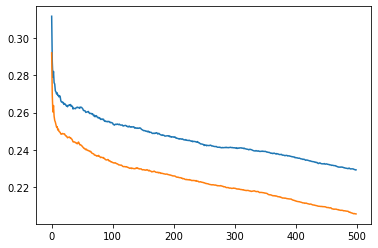

In [75]:
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["test-merror-mean"])
plt.plot(range(xgbCvResult.shape[0]), xgbCvResult["train-merror-mean"]);

In [76]:
best_num_round = np.argmin(xgbCvResult["test-merror-mean"])
best_num_round

498

In [77]:
xgb.train?

**Сделаем прогноз для всей тестовой выборки.**

In [78]:
bestXgb = xgb.train(best_params, dtrain, num_boost_round=best_num_round)

[22:43:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-3.8/xgboost/src/learner.cc:627: 
Parameters: { "silent" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




In [29]:
dtest = xgb.DMatrix(test_df)

In [30]:
xgboost_predict_proba = bestXgb.predict(dtest)

In [34]:
xgboost_predict_proba

array([[1.06216796e-01, 3.45100880e-01, 5.45024779e-03, ...,
        5.33308685e-01, 8.06001946e-03, 8.93665769e-04],
       [1.43958971e-01, 3.85648251e-01, 5.37964329e-03, ...,
        4.48571354e-01, 1.43786045e-02, 9.84669314e-04],
       [6.43465519e-01, 2.24347398e-01, 7.78729504e-04, ...,
        1.29002810e-01, 1.94086845e-03, 2.19877824e-04],
       ...,
       [2.22614588e-04, 1.92043919e-03, 9.04889703e-01, ...,
        2.54762243e-04, 9.20723155e-02, 1.07666434e-04],
       [2.13807085e-04, 1.60604855e-03, 9.09108341e-01, ...,
        2.14373867e-04, 8.82892236e-02, 9.07786161e-05],
       [2.44098163e-04, 1.86945254e-03, 8.48672450e-01, ...,
        2.44511932e-04, 1.48320243e-01, 9.84316648e-05]], dtype=float32)

In [31]:
xgboost_prediction = np.argmax(xgboost_predict_proba, axis=1)

In [35]:
xgboost_prediction

array([5, 5, 1, ..., 3, 3, 3])

**Мы вычитали из целевых меток 1, теперь добавляем.**

In [32]:
xgboost_prediction += 1

In [33]:
write_to_submission_file(xgboost_prediction, "forest_cover_type_xgboost.csv")

**У такой посылки на Kaggle результат - 0.771.**